In [1]:
import numpy as np
import pandas as pd
import scipy.stats

pd.options.mode.chained_assignment = None
from matplotlib import pyplot as plt, rcParams
# import cv2
import seaborn as sns

sns.set(style="white", context="paper")
from cycler import cycler
import os, sys
import glob
from datetime import datetime, timedelta
from itertools import combinations, product
import base64
from PIL import Image
from io import BytesIO as _BytesIO
import requests
import json
import pickle
from datetime import datetime
from IPython.display import display, Markdown, Latex
from sklearn.metrics import *
import collections
from copy import deepcopy
import traceback
from sympy import Point, Polygon
from decorators import *
from smartprint import smartprint as sprint
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN
import mmcv
from mmtrack.apis import inference_mot, init_model as init_tracking_model
# import plotly
# from pandas_profiling import ProfileReport

pd.options.display.max_columns = None
def printm(s): return display(Markdown(s))
    
SERVER_CACHE_DIR = '/mnt/ci-nas-cache/edulyzeV2/cache_compute_4/fixed_face'
os.makedirs(SERVER_CACHE_DIR,exist_ok=True)

track_analysis_meta_cache = f'{SERVER_CACHE_DIR}/analysis_tracking/meta_info'
base_dir = '/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb_fixed_face/'

track_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_tracking/session_tracking_info'
os.makedirs(track_analysis_session_data,exist_ok=True)

postprocessed_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/processed_id_maps'
os.makedirs(postprocessed_id_map_data_dir, exist_ok=True)

emb_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_emb/session_emb_info_new'
os.makedirs(emb_analysis_session_data,exist_ok=True)

embmatched_id_raw_data_dir = f'{SERVER_CACHE_DIR}/analysis_emb/embmatched_id_raw'
os.makedirs(embmatched_id_raw_data_dir,exist_ok=True)

embmatched_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/embmatched_id_maps'
os.makedirs(embmatched_id_map_data_dir, exist_ok=True)

cross_session_input_data_dir = f'{SERVER_CACHE_DIR}/analysis_emb/cross_session_input'
os.makedirs(cross_session_input_data_dir, exist_ok=True)

id_viz_cache_root = f'{SERVER_CACHE_DIR}/analysis_emb/session_matching_info'
os.makedirs(id_viz_cache_root, exist_ok=True)

/home/prasoon/anaconda3/envs/edusense/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/prasoon/anaconda3/envs/edusense/lib/python3.9/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


## Get frame file data for all sessions

In [2]:

frame_file_data = {}
for course_idx, course_dir in enumerate(glob.glob(f"{base_dir}/*")):
    course_name = course_dir.split("/")[-1]
    course_cache_file = f"{track_analysis_meta_cache}/{course_name}"
    if os.path.exists(course_cache_file):
        frame_file_data[course_name] = pickle.load(open(course_cache_file,"rb"))
        continue
    frame_file_data[course_name]={}
        
    for session_idx, session_dir in enumerate(glob.glob(f"{course_dir}/*")):
        session_name = session_dir.split("/")[-1]
        frame_file_data[course_name][session_name] = {}
        frame_files = glob.glob(f"{session_dir}/*")
        frame_file_names = [xr.split("/")[-1] for xr in frame_files]
        if 'end.pb' in frame_file_names:
            frame_file_data[course_name][session_name]['is_completed']=True
        else:
            frame_file_data[course_name][session_name]['is_completed']=False            
        frame_ids = [int(xr.split(".")[0]) for xr in frame_file_names if not (xr=='end.pb')]
        frame_file_data[course_name][session_name]['frame_ids'] = sorted(frame_ids)
        frame_file_data[course_name][session_name]['dir_location'] = session_dir
        print(f"Got metadata for course: {course_idx}-{course_name}, session:{session_idx}-{session_name}")
    pickle.dump(frame_file_data[course_name],open(course_cache_file,"wb")) 
        
frame_file_data.keys()

dict_keys(['05748A', '05410B', '17214C', '17214B', '05681A', '24352A', '24352C', '86375A'])

In [3]:
session_filter_list = ['classinsight-cmu_05681A_ghc_4301_201905011630',
 'classinsight-cmu_05681A_ghc_4301_201904171630',
 'classinsight-cmu_05681A_ghc_4301_201902201630',
 'classinsight-cmu_05681A_ghc_4301_201904101630',
 'classinsight-cmu_05681A_ghc_4301_201901231630',
                       
 'classinsight-cmu_05418A_ghc_4102_201902251200',
 'classinsight-cmu_05418A_ghc_4102_201904081200',
 'classinsight-cmu_05418A_ghc_4102_201905011200',
 'classinsight-cmu_05418A_ghc_4102_201904291200',
 'classinsight-cmu_05418A_ghc_4102_201904011200',
                       
 'classinsight-cmu_05748A_ghc_4101_201902141630',
 'classinsight-cmu_05748A_ghc_4101_201904021630',
 'classinsight-cmu_05748A_ghc_4101_201902051630',
 'classinsight-cmu_05748A_ghc_4101_201902281630',
 'classinsight-cmu_05748A_ghc_4101_201903071630',
                       
 'classinsight-cmu_21127J_ghc_4102_201904230930',
 'classinsight-cmu_21127J_ghc_4102_201903260930',
 'classinsight-cmu_21127J_ghc_4102_201904160930',
 'classinsight-cmu_21127J_ghc_4102_201904300930',
 'classinsight-cmu_21127J_ghc_4102_201903190930',
                       
 'classinsight-cmu_05410A_ghc_4301_201904151500',
 'classinsight-cmu_05410A_ghc_4301_201902251500',
 'classinsight-cmu_05410A_ghc_4301_201904081500',
 'classinsight-cmu_05410A_ghc_4301_201904221500',
 'classinsight-cmu_05410A_ghc_4301_201902181500',
                       
 'classinsight-cmu_17214B_ph_a21_201902271030',
 'classinsight-cmu_17214B_ph_a21_201903061030',
 'classinsight-cmu_17214B_ph_a21_201904031030',
 'classinsight-cmu_17214B_ph_a21_201904101030',
 'classinsight-cmu_17214B_ph_a21_201904241030',
                       
 'classinsight-cmu_17214C_ph_225b_201904031130',
 'classinsight-cmu_17214C_ph_225b_201904101130',
 'classinsight-cmu_17214C_ph_225b_201904171130',
 'classinsight-cmu_17214C_ph_225b_201904241130',
 'classinsight-cmu_17214C_ph_225b_201905011130',
                       
 'classinsight-cmu_05410B_ghc_4211_201902111500',
 'classinsight-cmu_05410B_ghc_4211_201903181500',
 'classinsight-cmu_05410B_ghc_4211_201904081500',
 'classinsight-cmu_05410B_ghc_4211_201904151500',
 'classinsight-cmu_05410B_ghc_4211_201904221500',
 'classinsight-cmu_05410B_ghc_4211_201901281500'
]

# Get vizualization for single session

In [4]:
sample_course = '05410B'
sample_session_id = 'classinsight-cmu_05410B_ghc_4211_201904081500-front'
session_tracking_cache_file = f"{track_analysis_session_data}/{sample_session_id}.pb"
session_preprocessed_id_map_file = f"{postprocessed_id_map_data_dir}/{sample_session_id}.pb"
session_frame_dir = f'{base_dir}/{sample_course}/{sample_session_id}'
session_video_file = f'/mnt/ci-nas-classes/classinsight/2019S/video_backup/{sample_session_id.split("-front")[0]}/{sample_session_id}.avi'
session_frame_dir

'/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb_fixed_face//05410B/classinsight-cmu_05410B_ghc_4211_201904081500-front'

In [5]:
old_to_new_id_map = pickle.load(open(session_preprocessed_id_map_file,"rb"))
df_session_eligible_pairs = pd.read_csv(f"{embmatched_id_map_data_dir}/{sample_session_id}.csv")
# Correct new ids with dict from eligible pairs
eligible_id_map_dict = {}
for id_pair in df_session_eligible_pairs.id_pair.values:
    (id1, id2) = eval(id_pair)
    print(id1, id2)
    if id2 in eligible_id_map_dict:
        eligible_id_map_dict[id1] = eligible_id_map_dict[id2]
    else:
        eligible_id_map_dict[id2] = id1

sprint(eligible_id_map_dict)

# correct created eligible map for once more
for key in sorted(list(eligible_id_map_dict.keys())):
    key_value = eligible_id_map_dict[key]
    if key_value in eligible_id_map_dict.keys():
        eligible_id_map_dict[key] = eligible_id_map_dict[key_value]
sprint(eligible_id_map_dict) 
# sprint({kr:old_to_new_id_map[kr] for kr in old_to_new_id_map if (not old_to_new_id_map[kr]==10000)}) 
sprint("replacing ids in old to new id maps")
for old_id in old_to_new_id_map:
    if old_to_new_id_map[old_id] in eligible_id_map_dict:
        print(f"replacing {old_id}:{old_to_new_id_map[old_id]} -->{eligible_id_map_dict[old_to_new_id_map[old_id]]}")
        old_to_new_id_map[old_id] = eligible_id_map_dict[old_to_new_id_map[old_id]]
# sprint({kr:old_to_new_id_map[kr] for kr in old_to_new_id_map if (not old_to_new_id_map[kr]==10000)}) 


4 16
8 29
11 16
11 17
11 26
14 19
18 29
Dict: eligible_id_map_dict
Key: Value


{11: 4, 16: 4, 17: 11, 18: 8, 19: 14, 26: 11, 29: 8}

Dict: eligible_id_map_dict
Key: Value


{11: 4, 16: 4, 17: 4, 18: 8, 19: 14, 26: 4, 29: 8}

"replacing ids in old to new id maps" : replacing ids in old to new id maps
replacing 52:11 -->4
replacing 86:16 -->4
replacing 87:17 -->4
replacing 105:18 -->8
replacing 121:19 -->14
replacing 300:26 -->4
replacing 352:29 -->8
replacing 221:16 -->4
replacing 138:19 -->14
replacing 702:16 -->4
replacing 370:26 -->4


In [6]:
# map processed ids to tracking df
df_tracking_new = pickle.load(open(session_tracking_cache_file,"rb")).transpose()
total_idxs = df_tracking_new.index.max()
for old_id in old_to_new_id_map:
    new_id = old_to_new_id_map[old_id]
    if not new_id==10000:
        new_id_col = f'N{new_id}'
        if new_id_col not in df_tracking_new:
            df_tracking_new[new_id_col] = None
        df_tracking_new[new_id_col] =  df_tracking_new[old_id].where(~df_tracking_new[old_id].isnull(), df_tracking_new[old_id])
    df_tracking_new = df_tracking_new.drop(old_id, axis=1)




In [7]:
col_start_stop_idxs = []
for col in df_tracking_new.columns:
    one_idxs = df_tracking_new.index[np.where(df_tracking_new[col]==1)[0]].values
    col_start_stop_idxs.append([col, one_idxs.min(), one_idxs.max()])
df_id_start_stop = pd.DataFrame(col_start_stop_idxs, columns=['id','min_idx','max_idx'])
df_id_start_stop['total_idxs'] = df_id_start_stop['max_idx']-df_id_start_stop['min_idx']
df_id_start_stop['id'] = df_id_start_stop['id'].apply(lambda x: int(x[1:]))
df_id_start_stop

,id,min_idx,max_idx,total_idxs
0,0,60762,71991,11229
1,1,39234,43644,4410
2,2,42180,71214,29034
3,3,78,71991,71913
4,4,52446,71991,19545
5,5,195,71055,70860
6,6,321,71991,71670
7,7,321,1485,1164
8,8,26481,45450,18969
9,9,861,37800,36939


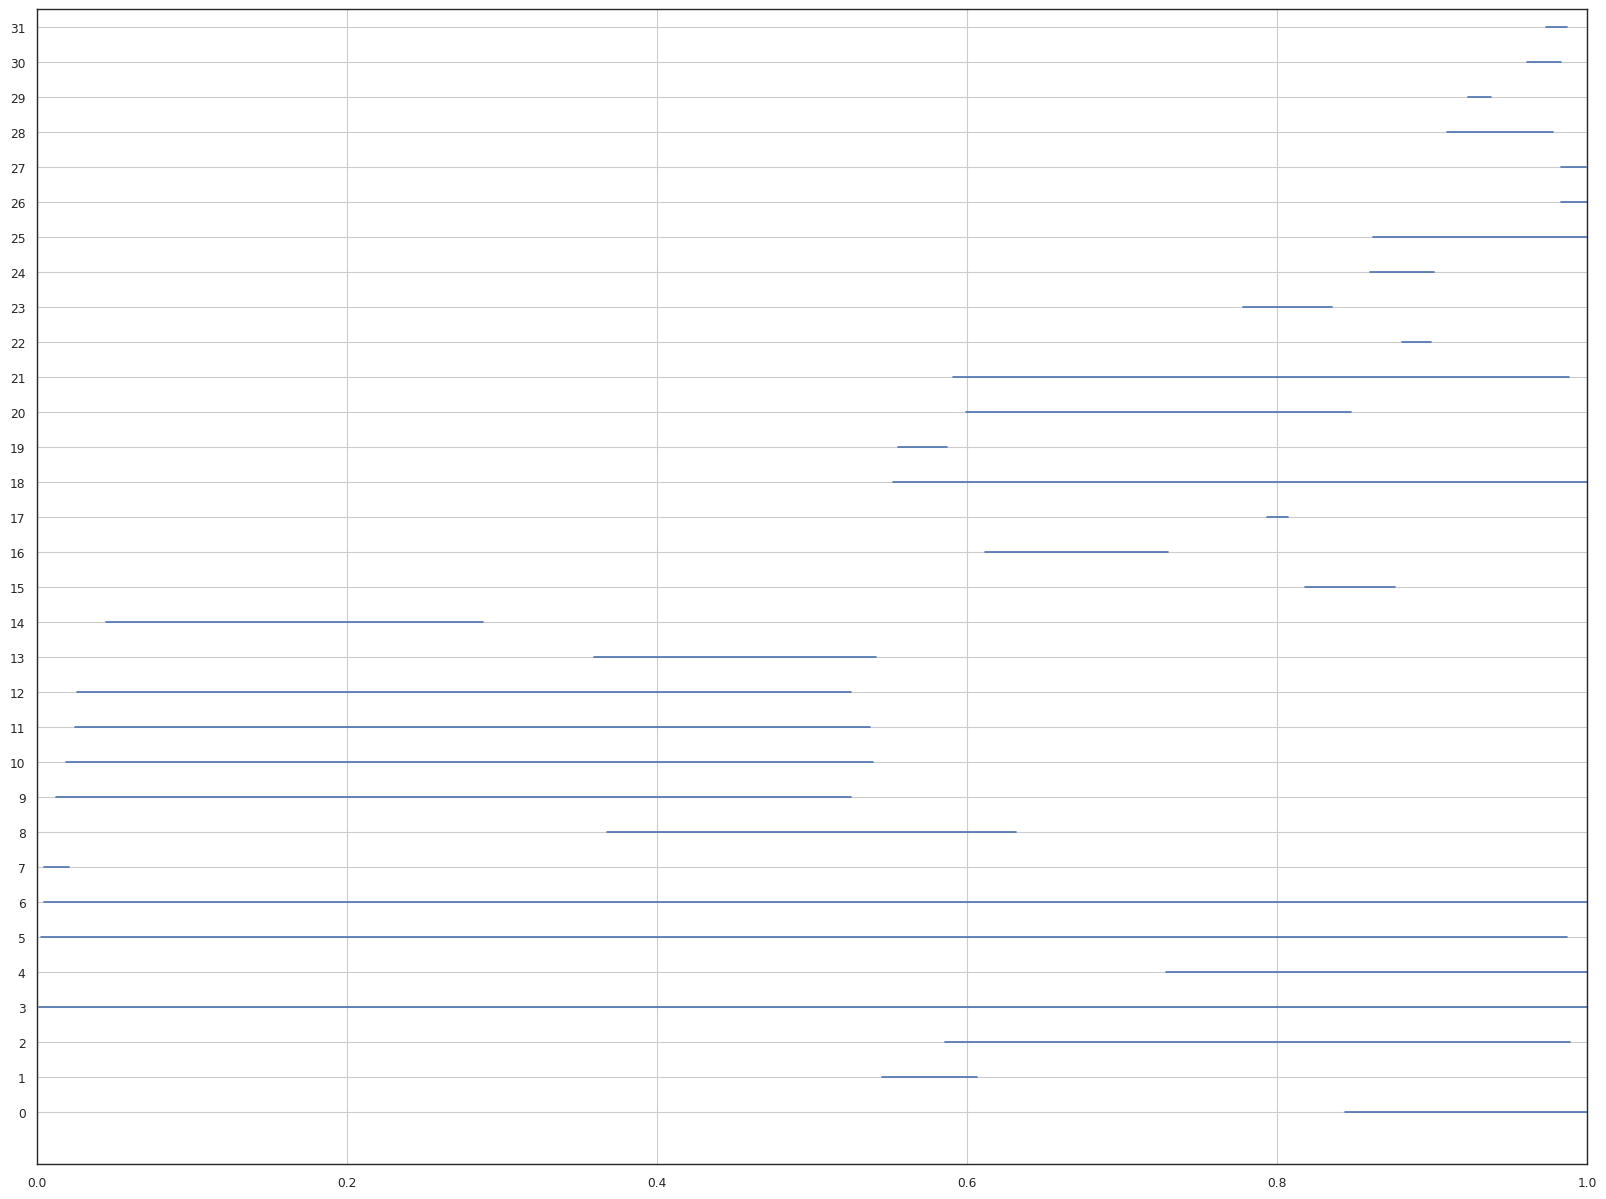

In [8]:
_ = plt.figure(figsize=(20,15))
for row_idx, row in df_id_start_stop.iterrows():
    plt.axhline(y=row_idx, xmin=row['min_idx']/total_idxs,xmax=row['max_idx']/total_idxs)
plt.yticks(range(df_id_start_stop.shape[0]), range(df_id_start_stop.shape[0]))
plt.grid() 

In [9]:
session_frames = df_tracking_new.index.values.tolist()
session_ids_covered = []
selected_frames = []
segments = []
segment_half_size = 50
for row_idx, row in df_id_start_stop.sort_values(by='total_idxs').iterrows():
    id_start, id_stop = row['min_idx'],row['max_idx']
    seg_mid = (id_start+id_stop)/2
    seg_start, seg_end = max(seg_mid-segment_half_size, 0), min(seg_mid+segment_half_size, total_idxs)
    is_id_covered = df_id_start_stop.apply(lambda row: (seg_end<=row['max_idx']) & (seg_start>=row['min_idx']),axis=1)
    seg_ids_covered = df_id_start_stop[is_id_covered]['id']
    new_ids_covered = [xr for xr in seg_ids_covered if xr not in session_ids_covered]
    if len(new_ids_covered)>0:        
        segment_frames = [xr for xr in session_frames if ((xr>=seg_start) and (xr<=seg_end))]
        selected_frames+=segment_frames
        segments.append((seg_start, seg_end, new_ids_covered, segment_frames))
        session_ids_covered+=new_ids_covered

sprint(segments)
    
    


List: segments


[
    (
        57562.0,
        57662.0,
        [2, 3, 4, 5, 6, 22, 23, 25, 27, 30],
        [
            57564,
            57567,
            57570,
            57573,
            57576,
            57579,
            57582,
            57585,
            57588,
            57591,
            57594,
            57597,
            57600,
            57603,
            57606,
            57609,
            57612,
            57615,
            57618,
            57621,
            57624,
            57627,
            57630,
            57633,
            57636,
            57639,
            57642,
            57645,
            57648,
            57651,
            57654,
            57657,
            57660
        ]
    ),
    (
        70514.5,
        70614.5,
        [0, 32, 37, 38],
        [
            70515,
            70518,
            70521,
            70524,
            70527,
            70530,
            70533,
            70536,
            70539,
            70542,
            70545,
            70548,
            70551,
            70554,
            70557,
            70560,
            70563,
            70566,
            70569,
            70572,
            70575,
            70578,
            70581,
            70584,
            70587,
            70590,
            70593,
            70596,
            70599,
            70602,
            70605,
            70608,
            70611,
            70614
        ]
    ),
    (
        66938.5,
        67038.5,
        [35, 36],
        [
            66939,
            66942,
            66945,
            66948,
            66951,
            66954,
            66957,
            66960,
            66963,
            66966,
            66969,
            66972,
            66975,
            66978,
            66981,
            66984,
            66987,
            66990,
            66993,
            66996,
            66999,
            67002,
            67005,
            67008,
            67011,
            67014,
            67017,
            67020,
            67023,
            67026,
            67029,
            67032,
            67035,
            67038
        ]
    ),
    (
        853.0,
        953.0,
        [7],
        [
            855,
            858,
            861,
            864,
            867,
            870,
            873,
            876,
            879,
            882,
            885,
            888,
            891,
            894,
            897,
            900,
            903,
            906,
            909,
            912,
            915,
            918,
            921,
            924,
            927,
            930,
            933,
            936,
            939,
            942,
            945,
            948,
            951
        ]
    ),
    (
        71323.0,
        71423.0,
        [33, 34],
        [
            71325,
            71328,
            71331,
            71334,
            71337,
            71340,
            71343,
            71346,
            71349,
            71352,
            71355,
            71358,
            71361,
            71364,
            71367,
            71370,
            71373,
            71376,
            71379,
            71382,
            71385,
            71388,
            71391,
            71394,
            71397,
            71400,
            71403,
            71406,
            71409,
            71412,
            71415,
            71418,
            71421
        ]
    ),
    (
        64030.0,
        64130.0,
        [28, 31],
        [
            64032,
            64035,
            64038,
            64041,
            64044,
            64047,
            64050,
            64053,
            64056,
            64059,
            64062,
            64065,
            64068,
            64071,
            64074,
            64077,
            64080,
            64083,
            64086,
            64089

In [10]:
SOURCE_ROOT = '/home/prasoon/video_analysis/edusenseV2compute/compute/videoV3'
run_config = {
    'track_config':f'{SOURCE_ROOT}/configs/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half.py',
    'track_checkpoint':f'{SOURCE_ROOT}/models/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half_20220813_101618-fe150582.pth',
    'device':'cuda:1',
}


In [11]:
# for given frame ranges get video frames and tracking results
all_frames = mmcv.VideoReader(session_video_file)

required_frame_ids = np.unique(sorted(selected_frames))
frame_data_dict = {}

for frame_idx, frame_img in enumerate(all_frames):
    if (frame_idx in required_frame_ids) & (frame_idx%3==0):
        frame_data_dict[frame_idx] = frame_img
    if frame_idx%10000==0:
        print(f"Looped {frame_idx} images")

[h264 @ 0xbb7cdc0] error while decoding MB 68 11, bytestream -7
[h264 @ 0xbb7cdc0] error while decoding MB 53 90, bytestream -7
[h264 @ 0xbb7cdc0] error while decoding MB 213 133, bytestream -7
[h264 @ 0xbef6d40] error while decoding MB 68 11, bytestream -7
[h264 @ 0xbfee400] error while decoding MB 53 90, bytestream -7
[h264 @ 0xbee5380] error while decoding MB 213 133, bytestream -7
[h264 @ 0xb92d340] error while decoding MB 107 92, bytestream -5
[h264 @ 0xbef6d40] error while decoding MB 68 11, bytestream -7
[h264 @ 0xbfee400] error while decoding MB 53 90, bytestream -7
[h264 @ 0xbee5380] error while decoding MB 213 133, bytestream -7
[h264 @ 0xb92d340] error while decoding MB 107 92, bytestream -5


Looped 0 images


[h264 @ 0xbacb7c0] error while decoding MB 72 118, bytestream -5
[h264 @ 0xbaf3fc0] error while decoding MB 20 85, bytestream -5
[h264 @ 0xbb1ca40] error while decoding MB 35 95, bytestream -5
[h264 @ 0xbef6d40] error while decoding MB 106 85, bytestream -5
[h264 @ 0xbacb7c0] error while decoding MB 176 126, bytestream -10
[h264 @ 0xbaf3fc0] error while decoding MB 193 104, bytestream -5
[h264 @ 0xbb1ca40] error while decoding MB 156 116, bytestream -7
[h264 @ 0xbb9ac80] error while decoding MB 16 87, bytestream -9
[h264 @ 0xbef6d40] error while decoding MB 48 85, bytestream -9


Looped 10000 images


[h264 @ 0xb92d340] error while decoding MB 2 133, bytestream -7
[h264 @ 0xbacb7c0] error while decoding MB 210 80, bytestream -5
[h264 @ 0xbaf3fc0] error while decoding MB 190 50, bytestream -5
[h264 @ 0xbb1ca40] error while decoding MB 174 50, bytestream -5
[h264 @ 0xbb9ac80] error while decoding MB 86 51, bytestream -13
[h264 @ 0xbef6d40] error while decoding MB 92 50, bytestream -7
[h264 @ 0xbed0f80] error while decoding MB 88 68, bytestream -7
[h264 @ 0xb78eec0] error while decoding MB 111 66, bytestream -11
[h264 @ 0xb92d340] error while decoding MB 25 67, bytestream -5
[h264 @ 0xbacb7c0] error while decoding MB 43 50, bytestream -5
[h264 @ 0xbaf3fc0] error while decoding MB 32 53, bytestream -5
[h264 @ 0xbb1ca40] error while decoding MB 172 56, bytestream -13
[h264 @ 0xbb9ac80] error while decoding MB 46 87, bytestream -5
[h264 @ 0xbef6d40] error while decoding MB 27 81, bytestream -5
[h264 @ 0xbed0f80] error while decoding MB 214 66, bytestream -5
[h264 @ 0xb78eec0] error while 

Looped 20000 images


[h264 @ 0xb9fc580] left block unavailable for requested intra mode
[h264 @ 0xb9fc580] error while decoding MB 0 91, bytestream 155050
[h264 @ 0xbaf3fc0] error while decoding MB 44 81, bytestream -11
[h264 @ 0xbb1ca40] error while decoding MB 68 86, bytestream -6
[h264 @ 0xbef6d40] error while decoding MB 14 86, bytestream -9
[h264 @ 0xbacb7c0] error while decoding MB 48 88, bytestream -11
[h264 @ 0xbaf3fc0] error while decoding MB 231 84, bytestream -5
[h264 @ 0xbb1ca40] error while decoding MB 6 89, bytestream -5


Looped 30000 images


[h264 @ 0xbef6d40] error while decoding MB 36 84, bytestream -5
[h264 @ 0xbb08500] error while decoding MB 161 100, bytestream -14
[h264 @ 0xbb30f80] error while decoding MB 140 107, bytestream -12
[h264 @ 0xbfa60c0] error while decoding MB 29 110, bytestream -41
[h264 @ 0xbfee400] error while decoding MB 8 116, bytestream -22
[h264 @ 0xbee5380] error while decoding MB 68 117, bytestream -6
[h264 @ 0xb85e100] error while decoding MB 103 115, bytestream -14
[h264 @ 0xb9fc580] error while decoding MB 6 118, bytestream -12
[h264 @ 0xbadfbc0] error while decoding MB 186 126, bytestream -30
[h264 @ 0xbb08500] error while decoding MB 117 101, bytestream -34
[h264 @ 0xbb30f80] error while decoding MB 146 108, bytestream -30
[h264 @ 0xbfa60c0] error while decoding MB 4 98, bytestream -24
[h264 @ 0xbfee400] error while decoding MB 152 109, bytestream -6
[h264 @ 0xbee5380] error while decoding MB 160 112, bytestream -10
[h264 @ 0xb85e100] error while decoding MB 213 106, bytestream -12
[h264 @ 0

Looped 40000 images


[h264 @ 0xbb08500] error while decoding MB 23 92, bytestream -10
[h264 @ 0xbb30f80] error while decoding MB 33 98, bytestream -20
[h264 @ 0xbfa60c0] error while decoding MB 149 100, bytestream -24
[h264 @ 0xbfee400] error while decoding MB 106 110, bytestream -14
[h264 @ 0xbee5380] error while decoding MB 144 101, bytestream -12
[h264 @ 0xb85e100] error while decoding MB 154 108, bytestream -30
[h264 @ 0xb9fc580] error while decoding MB 199 107, bytestream -8
[h264 @ 0xbadfbc0] error while decoding MB 183 109, bytestream -20
[h264 @ 0xbb08500] error while decoding MB 82 92, bytestream -6
[h264 @ 0xbb30f80] error while decoding MB 236 101, bytestream -7
[h264 @ 0xbfa60c0] error while decoding MB 11 103, bytestream -8
[h264 @ 0xbfee400] error while decoding MB 210 100, bytestream -6
[h264 @ 0xbee5380] error while decoding MB 200 5, bytestream -24
[h264 @ 0xb85e100] error while decoding MB 164 96, bytestream -9
[h264 @ 0xb9fc580] error while decoding MB 157 100, bytestream -18
[h264 @ 0xb

Looped 50000 images


[h264 @ 0xbadfbc0] error while decoding MB 92 94, bytestream -26
[h264 @ 0xbb08500] error while decoding MB 141 82, bytestream -12
[h264 @ 0xbb30f80] error while decoding MB 156 93, bytestream -8
[h264 @ 0xbfa60c0] error while decoding MB 192 86, bytestream -18
[h264 @ 0xbfee400] error while decoding MB 212 91, bytestream -16
[h264 @ 0xbee5380] error while decoding MB 110 95, bytestream -14
[h264 @ 0xb85e100] error while decoding MB 3 97, bytestream -28
[h264 @ 0xbadfbc0] error while decoding MB 73 115, bytestream -12
[h264 @ 0xbb08500] error while decoding MB 220 115, bytestream -7
[h264 @ 0xbb30f80] error while decoding MB 116 126, bytestream -14
[h264 @ 0xbfa60c0] error while decoding MB 39 133, bytestream -12
[h264 @ 0xbfee400] error while decoding MB 135 116, bytestream -10
[h264 @ 0xbee5380] error while decoding MB 144 123, bytestream -12
[h264 @ 0xb92d340] error while decoding MB 92 74, bytestream -5
[h264 @ 0xbacb7c0] error while decoding MB 204 62, bytestream -7
[h264 @ 0xbadf

Looped 60000 images


[h264 @ 0xb92d340] error while decoding MB 13 61, bytestream -5
[h264 @ 0xb9fc580] error while decoding MB 3 130, bytestream -22
[h264 @ 0xbadfbc0] error while decoding MB 5 111, bytestream -8
[h264 @ 0xbb08500] error while decoding MB 31 108, bytestream -18
[h264 @ 0xbb30f80] error while decoding MB 27 119, bytestream -14
[h264 @ 0xbfa60c0] error while decoding MB 31 118, bytestream -6
[h264 @ 0xbfee400] error while decoding MB 161 109, bytestream -8
[h264 @ 0xbee5380] error while decoding MB 110 117, bytestream -12
[h264 @ 0xb85e100] error while decoding MB 181 124, bytestream -22
[h264 @ 0xb9fc580] error while decoding MB 193 125, bytestream -24
[h264 @ 0xbadfbc0] error while decoding MB 5 111, bytestream -8
[h264 @ 0xbb08500] error while decoding MB 202 114, bytestream -20
[h264 @ 0xbb30f80] error while decoding MB 27 120, bytestream -34
[h264 @ 0xbfa60c0] error while decoding MB 212 121, bytestream -12
[h264 @ 0xbfee400] error while decoding MB 177 111, bytestream -36
[h264 @ 0xbe

Looped 70000 images


[h264 @ 0xbfee400] error while decoding MB 27 100, bytestream -6
[h264 @ 0xbee5380] error while decoding MB 143 109, bytestream -32
[h264 @ 0xb85e100] error while decoding MB 239 116, bytestream -8
[h264 @ 0xb9fc580] error while decoding MB 8 116, bytestream -12


In [12]:
session_id_viz_dir = f'{id_viz_cache_root}/{sample_session_id}'
os.makedirs(session_id_viz_dir, exist_ok=True)
tracking_model =None
if tracking_model:
    printm("# Deleting Previous Model")
    del tracking_model
tracking_model = init_tracking_model(run_config['track_config'],
                                 run_config['track_checkpoint'],
                                 device=run_config['device'])
for seg_idx, (seg_start, seg_end, new_ids_covered, segment_frames) in enumerate(segments):
    seg_video_id = f'S{seg_idx}_{int(seg_start)}_{int(seg_end)}_{"_".join(map(str,new_ids_covered))}'
    match_cache_dir = f'{session_id_viz_dir}/{seg_video_id}'
    match_video_file = f'{session_id_viz_dir}/{seg_video_id}.mp4'
    if os.path.exists(match_video_file):
        continue
    print(match_video_file)
    os.makedirs(match_cache_dir, exist_ok=True)
    frame_num=0

    for frame_idx in segment_frames:
        frame_tracking_file = f"{session_frame_dir}/{frame_idx}.pb"
        if os.path.exists(frame_tracking_file) and (frame_idx in frame_data_dict):
            frame_file_out = os.path.join(match_cache_dir, f'{frame_num:06d}.jpg')
            frame_num+=1
            if os.path.exists(frame_file_out):
                continue
            frame_tracking_results = pickle.load(open(frame_tracking_file,"rb"))[1]
            for person_idx in range(len(frame_tracking_results)):
                old_id= int(frame_tracking_results[person_idx]['track_id'])
                frame_tracking_results[person_idx]['track_id'] =old_to_new_id_map[old_id]
            frame_img = deepcopy(frame_data_dict[frame_idx])
            if len(frame_tracking_results)>0:
                frame_tracking_results = {
                    'track_bboxes':[np.array([[xr['track_id']]+xr['bbox'].tolist() for xr in frame_tracking_results])],
                    'det_bboxes':[np.array([xr['bbox'].tolist() for xr in frame_tracking_results])]}
                frame_track_img = tracking_model.show_result(
                    frame_img,
                    frame_tracking_results,
                    thickness=5,
                    font_scale=.5,
                    score_thr=0.1,
                    show=False,
                    wait_time=int(1000. / 5),
                    out_file=frame_file_out,
                    backend='cv2')
            else:
                cv2.imwrite(frame_file_out,frame_img)
    
    #         break
    # break
    mmcv.frames2video(match_cache_dir, match_video_file, fps=5, fourcc='mp4v')
    print(f"Done for segment {seg_video_id}")
    # break
    
    

2023-09-03 20:04:01,086 - mmdet - INFO - image shape: height=800, width=1440 in YOLOX.__init__
2023-09-03 20:04:01,575 - mmtrack - INFO - initialize YOLOX with init_cfg {'type': 'Pretrained', 'checkpoint': 'https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth'}
2023-09-03 20:04:01,576 - mmcv - INFO - load model from: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2023-09-03 20:04:01,577 - mmcv - INFO - load checkpoint from http path: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2023-09-03 20:04:03,621 - mmcv - WARNING - The model and loaded state dict do not match exactly

size mismatch for bbox_head.multi_level_conv_cls.0.weight: copying a param with shape torch.Size([80, 320, 1, 1]) from checkpoint, the shape in current model is torch.Size([1, 320, 1, 

load checkpoint from local path: /home/prasoon/video_analysis/edusenseV2compute/compute/videoV3/models/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half_20220813_101618-fe150582.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: ema_detector_backbone_stem_conv_conv_weight, ema_detector_backbone_stem_conv_bn_weight, ema_detector_backbone_stem_conv_bn_bias, ema_detector_backbone_stem_conv_bn_running_mean, ema_detector_backbone_stem_conv_bn_running_var, ema_detector_backbone_stem_conv_bn_num_batches_tracked, ema_detector_backbone_stage1_0_conv_weight, ema_detector_backbone_stage1_0_bn_weight, ema_detector_backbone_stage1_0_bn_bias, ema_detector_backbone_stage1_0_bn_running_mean, ema_detector_backbone_stage1_0_bn_running_var, ema_detector_backbone_stage1_0_bn_num_batches_tracked, ema_detector_backbone_stage1_1_main_conv_conv_weight, ema_detector_backbone_stage1_1_main_conv_bn_weight, ema_detector_backbone_stage1_1_main_conv_bn_bias, ema_detector